In this notebook VGG16 (K. Simonyan and A. Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recognition”) is recreated to predict different species of flowers from the tf_flowers dataset. First the model is build from scratch and later transfer learning from already pre-trained VGG16 model is applied.
### Import libraries

In [1]:
import tensorflow as tf 

tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 9.0MB/s 


In [3]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix

### Load dataset
Load the dataset and define basic dataset preprocessing and sampling parameters.

In [4]:
dataset_name = 'tf_flowers'
batch_size = 128

@tf.function
def transform_inp(image, label):
  image = tf.image.resize_with_crop_or_pad(image, 224, 224)
  return tf.cast(image, tf.float32)/255., tf.one_hot(label, depth=5)

@tf.function
def transform_aug_inp(image, label):
  image = tfa.image.rotate(image, tf.constant((np.pi/18)*np.random.uniform(-1.,1.)))
  #image = tf.image.random_crop(image, size=[224, 224, 3])
  image = tf.image.resize_with_crop_or_pad(image, 250, 250)
  image = tf.image.random_crop(image, size=[224, 224, 3])
  #image = tf.image.resize(image, size=[224, 224])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  return tf.cast(image, tf.float32)/255., tf.one_hot(label, depth=5)

train_ds_org, info = tfds.load(dataset_name, split='train[:-20%]', as_supervised=True, with_info=True)
valid_ds_org = tfds.load(dataset_name, split='train[-20%:-10%]', as_supervised=True)
test_ds_org = tfds.load(dataset_name, split='train[-10%:]', as_supervised=True)

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).batch(batch_size)

Let's investigate some of the augmented images.

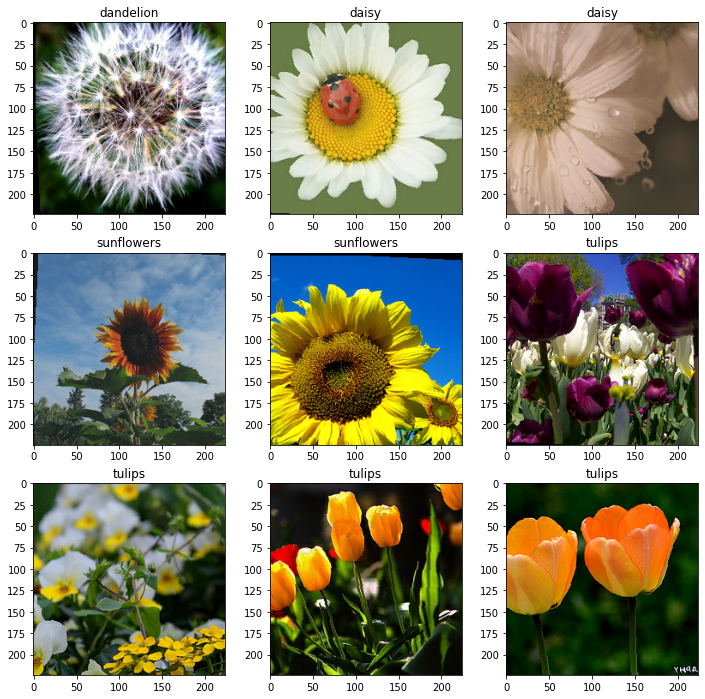

In [5]:
get_label_name = info.features['label'].int2str

plt.figure(figsize=(12,12)) 
for batch in train_ds.take(1):
  for i in range(9):
    img, label = batch[0][i], batch[1][i]
    plt.subplot(3,3,i+1)
    plt.title(get_label_name(np.argmax(label)))
    plt.imshow(img)
plt.show()

Plot indicates that some of the images are mislabeled (the bottom left corner).

### Model
We define our model following VGG16 architecture.

In [6]:
model = tf.keras.models.Sequential([
    
    #first budle (2 conv layers)
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                           padding='same', activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    #second budle (2 conv layers)
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    #third budle (3 conv layers)
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    #fifth bundle (3 conv layers)
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),  

    #fifth bundle (3 conv layers)
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),  
    
    #sixth fully connected bundle (13 conv layers + 3 dens)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

Let's check the model summary.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

### Defining the loss function and compiling the model

Here we define our optimizer, loss function, and necessary metrics.

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

### Plotting function
We define plotting function to investigate training of our model

In [9]:
def plot_conv(hist):                     
    history_dict = hist.history
    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    epochs = range(1, len(train_acc) + 1)
    axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[0].plot(epochs, train_loss, c='orange', label='Training loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    #axs[0].set_xscale('log')
    axs[0].legend()
    
    axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
    axs[1].plot(epochs, train_acc, c='orange', label='Training accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    #axs[1].set_xscale('log')
    axs[1].legend()
    plt.tight_layout()

    print("Final statistics")
    print("Training")
    print("Loss: {:.3f}  Accuracy: {:.3f}".format(train_loss[-1], train_acc[-1]))
    print("Validation")
    print("Loss: {:.3f}  Accuracy: {:.3f}".format(val_loss[-1], val_acc[-1]))

### Training

We train our model for 50 epochs to see how it performs.

Final statistics
Training
Loss: 0.409  Accuracy: 0.858
Validation
Loss: 1.341  Accuracy: 0.657


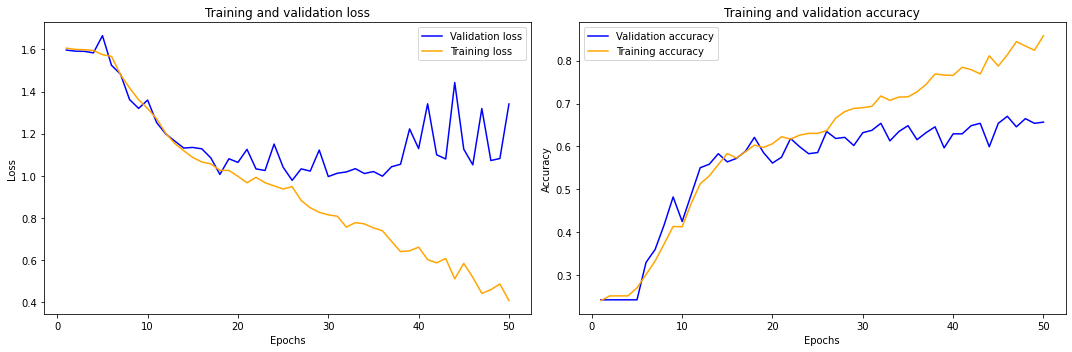

In [10]:
base_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Overfitting can be observed from around 20 epochs. To prevent it regularization could be applied combined with hyperparameters tunning. On the other hand, it will be definetly more beneficial to apply transfer learning. 
### Transfer learning
For that VGG16 will be used that was pre-trained on ImageNet. First, we freeze all VGG16 convulation weights and train only the added dens layers.

In [11]:
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [12]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________


Final statistics
Training
Loss: 0.823  Accuracy: 0.692
Validation
Loss: 0.848  Accuracy: 0.703


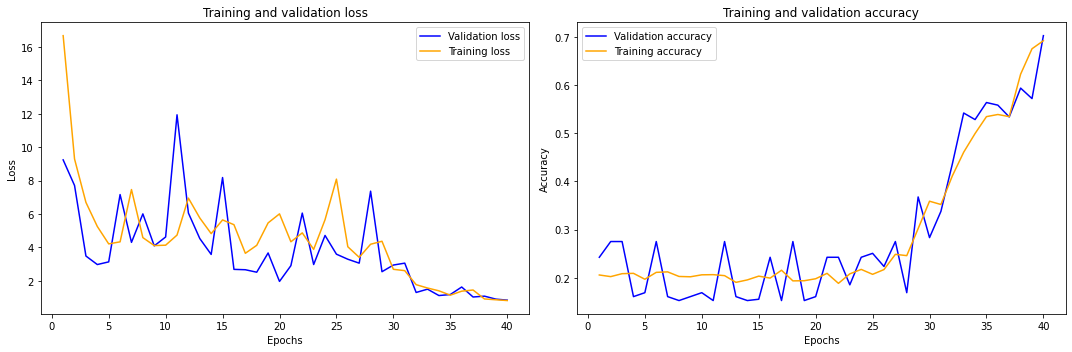

In [13]:
base_hist = model.fit(
    train_ds,
    epochs=40,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Learning rate of 0.01 is too big for pre-trained model. Let's try smaller values.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.192  Accuracy: 0.939
Validation
Loss: 0.605  Accuracy: 0.804


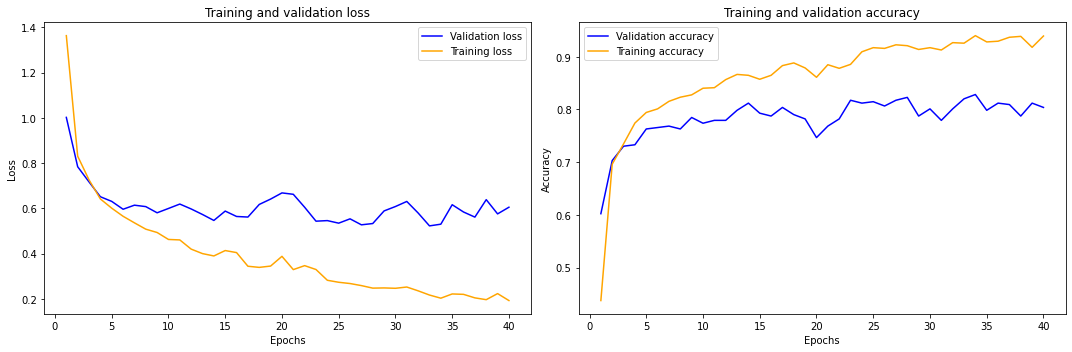

In [14]:
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=40,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.460  Accuracy: 0.848
Validation
Loss: 0.573  Accuracy: 0.785


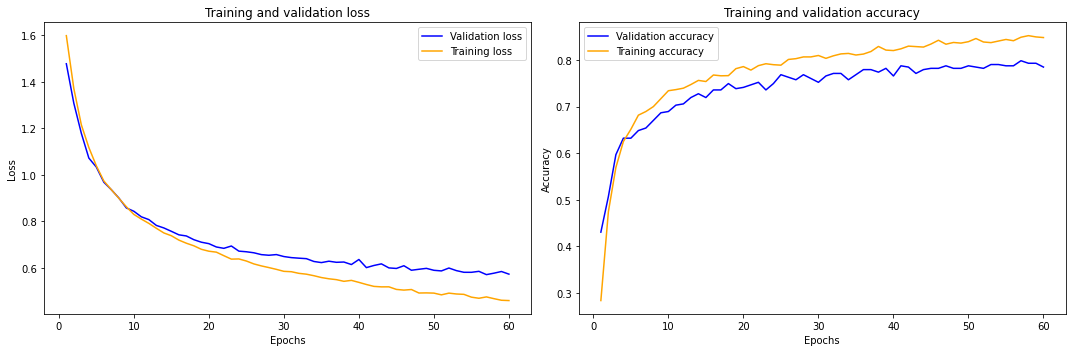

In [15]:
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=60,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Learning rate 0.001 works well and seem to be better than 0.0001. Now let's tune the batch size.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.117  Accuracy: 0.956
Validation
Loss: 0.711  Accuracy: 0.812


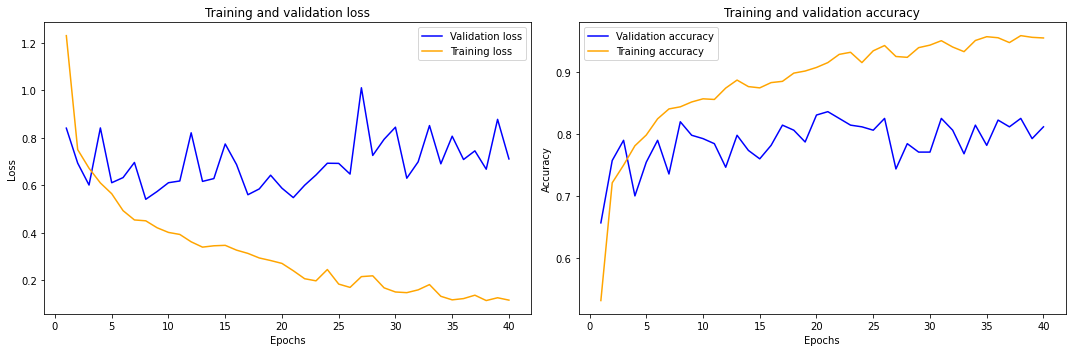

In [16]:
batch_size = 32

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)


base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=40,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.121  Accuracy: 0.965
Validation
Loss: 0.759  Accuracy: 0.790


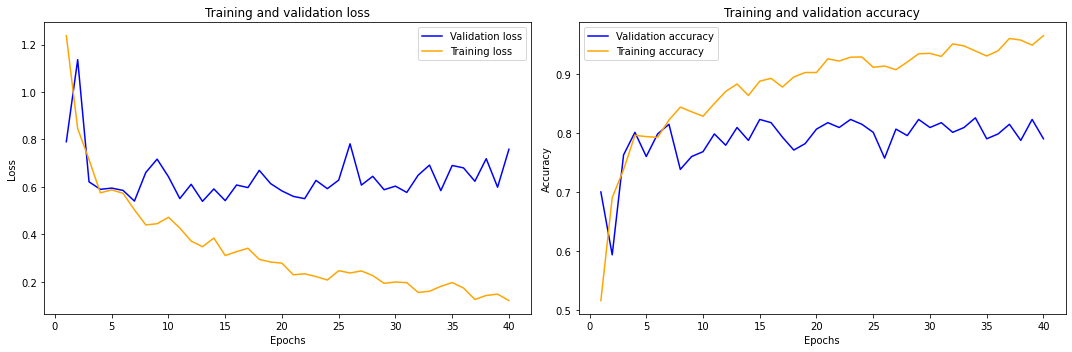

In [17]:
batch_size = 64

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)


base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=40,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 0.272  Accuracy: 0.919
Validation
Loss: 0.530  Accuracy: 0.820


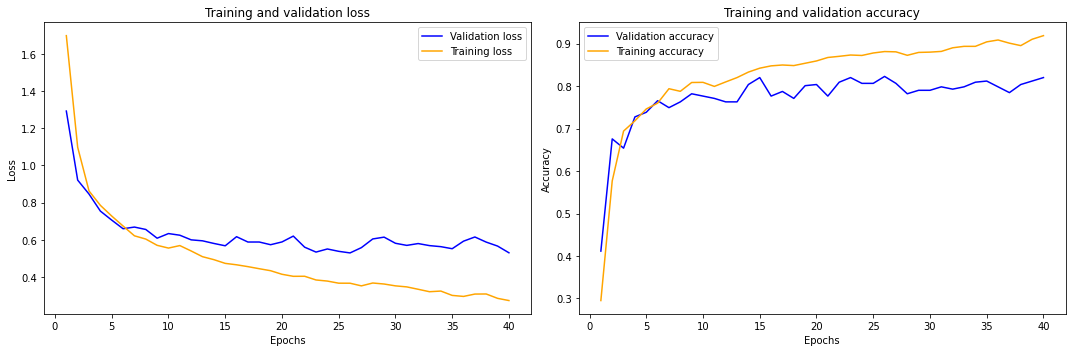

In [18]:
batch_size = 256

train_ds = train_ds_org.map(transform_aug_inp).shuffle(512).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds_org.map(transform_inp).shuffle(512).batch(batch_size)
test_ds = test_ds_org.map(transform_inp).shuffle(512).batch(batch_size)


base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(1024, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=40,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

The difference in validation accuracy between batch sizes is unnoticable. The batch size mostly influences "jumpness" of the plots. We decide to stick to the default batch size of 128.  
The overfit starts to occur from around 10 epochs. We can try to prevent it with regularization. For that we use l2-method.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 7.070  Accuracy: 0.885
Validation
Loss: 7.032  Accuracy: 0.823


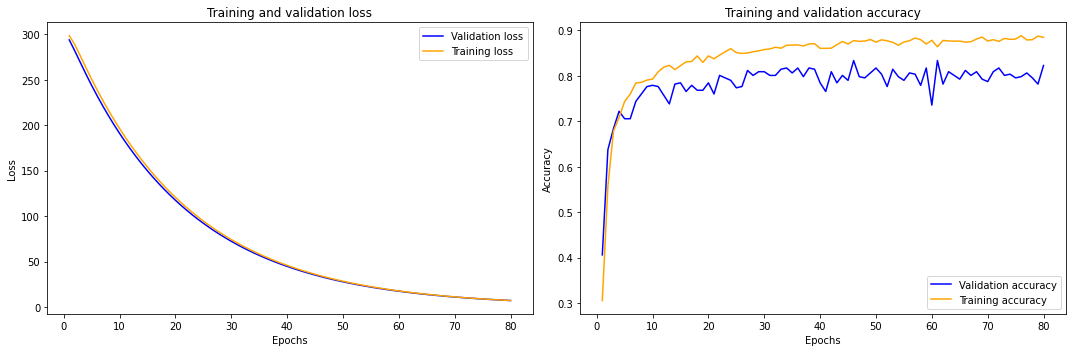

In [19]:
regularization = 0.1
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=80,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_42 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 26,745,861
Non-trainable params: 14,714,688
_________________________________________________________________
Final statistics
Training
Loss: 18.822  Accuracy: 0.963
Validation
Loss: 19.225  Accuracy: 0.804


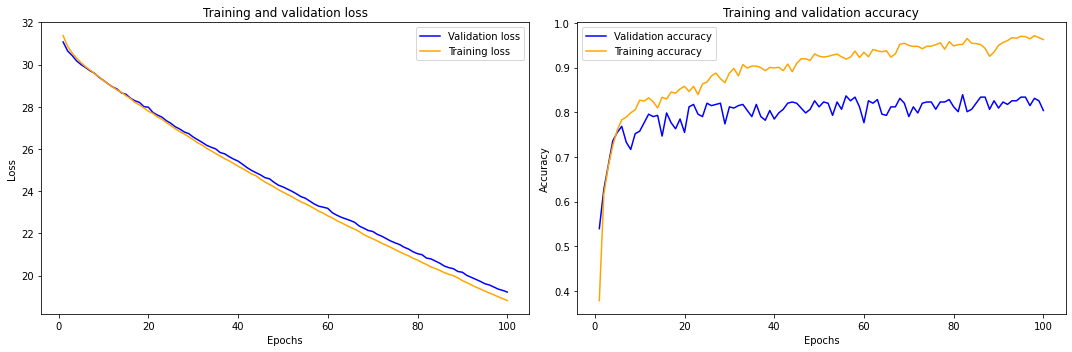

In [20]:
regularization = 0.01
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
base_model.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Validation accuracy is stable from 20 epochs but loss decrease seem to be constant. This may be connected with decreasing of regularization weights rather than improving predictions. To further improve accuracy we may try to train some extra layers of VGG16. We start from only the last layer.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 29,105,669
Non-trainable params: 12,354,880
_________________________________________________________________
Final statistics
Training
Loss: 3.431  Accuracy: 0.933
Validation
Loss: 3.464  Accuracy: 0.856


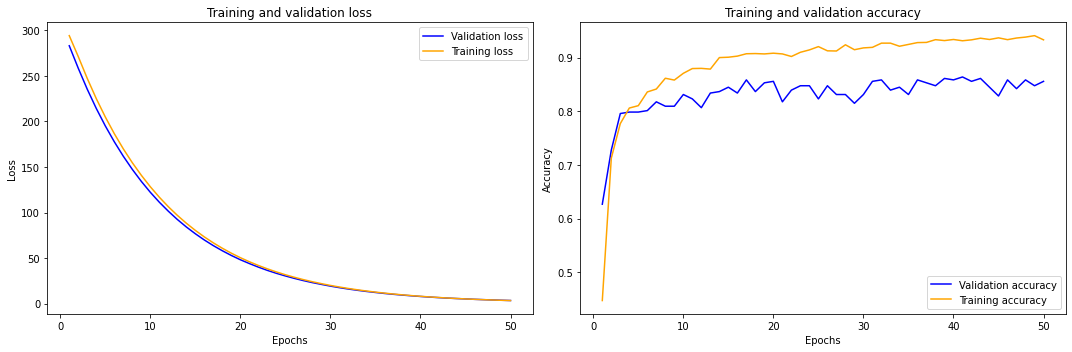

In [21]:
regularization = 0.1
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#only last layer
base_model.trainable = True
train_from = 17

for layer in base_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Predictions have improved. Let's try more layers.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 31,465,477
Non-trainable params: 9,995,072
_________________________________________________________________
Final statistics
Training
Loss: 3.252  Accuracy: 0.970
Validation
Loss: 3.394  Accuracy: 0.872


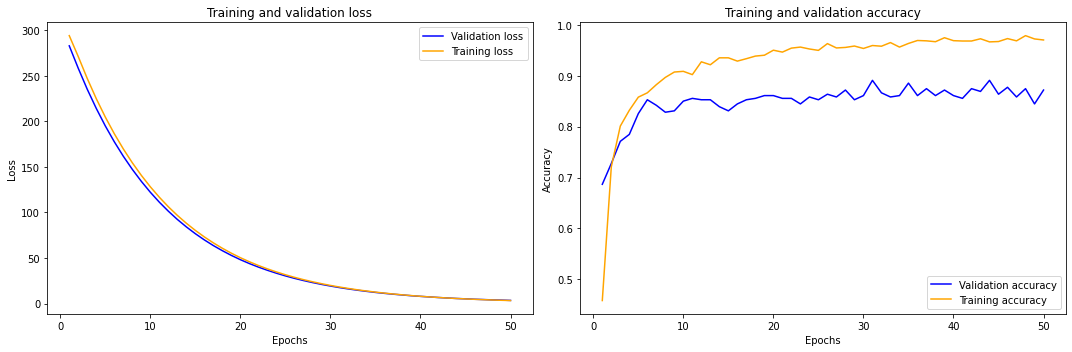

In [22]:
regularization = 0.1
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#two last layers
base_model.trainable = True
train_from = 16

for layer in base_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 33,825,285
Non-trainable params: 7,635,264
_________________________________________________________________
Final statistics
Training
Loss: 3.151

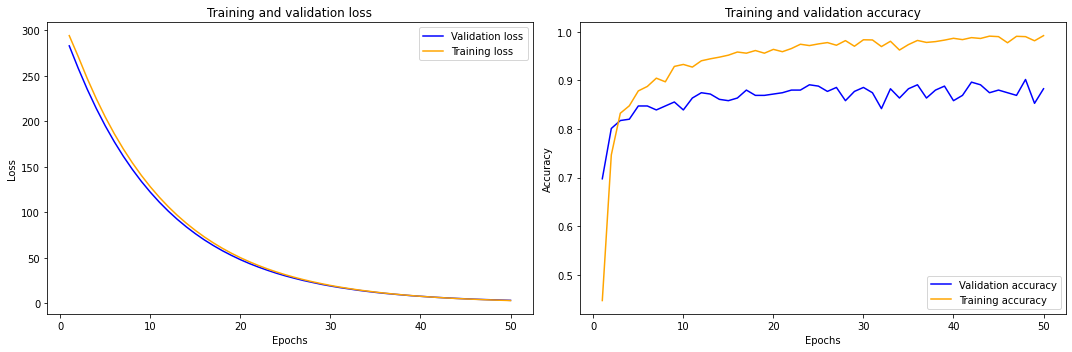

In [23]:
regularization = 0.1
base_model = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#three last layers
base_model.trainable = True
train_from = 15

for layer in base_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model.summary()

base_hist = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist)

Accuracy of 88.3% is a nice boost when compared to the previous values and training of the last three layers seem to be sufficient. Let's now see if a little more of regularization helps.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 41,460,549
Trainable params: 33,825,285
Non-trainable params: 7,635,264
_________________________________________________________________
Final statistics
Training
Loss: 0.192  Accuracy: 0.991
Validation
Loss: 0.562  Accuracy: 0.896


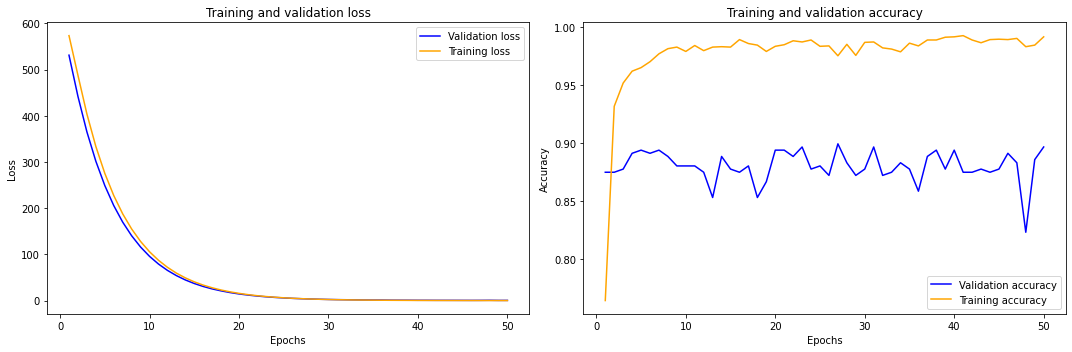

In [24]:
regularization = 0.2
base_model2 = tf.keras.applications.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
#three last layers
base_model2.trainable = True
train_from = 15

for layer in base_model.layers[:train_from]:
  print(layer)
  layer.trainable = False

model2 = tf.keras.models.Sequential()
model2.add(base_model)
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model2.add(tf.keras.layers.Dense(1024, activation='elu',
          kernel_regularizer=regularizers.l2(regularization)))
model2.add(tf.keras.layers.Dense(5, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])
model2.summary()

base_hist2 = model2.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds, 
    verbose = 0
)

plot_conv(base_hist2)

For this model accuracy of 89.6% has been achieved but it is rather a result of random fluctuations. Let's now investigate a validation split.
### Validation split

Number of mistakes by label:

{'dandelion': 12, 'daisy': 2, 'tulips': 8, 'sunflowers': 8, 'roses': 8}


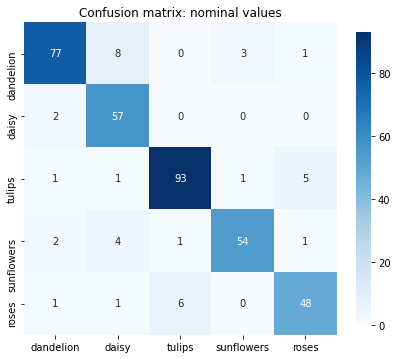

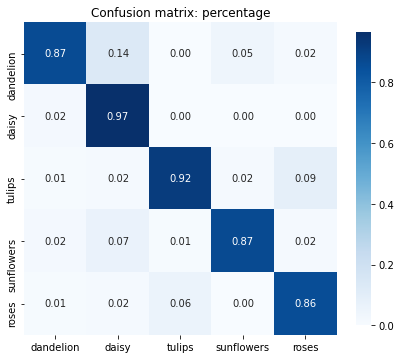

In [25]:
pred = model2.predict(valid_ds)
pred_lbl = np.argmax(pred, axis = 1)
true_val = np.concatenate([lbl for img, lbl in valid_ds], axis=0)
true_val_lbl = np.argmax(true_val, axis = 1)

def plot_conf(true, pred, norm = False):
  _ , ax = plt.subplots(figsize =(7, 6))
  conf = confusion_matrix(true, pred)
  fmt = 'd'
  ax_lbl = info.features['label'].names
  if norm:
    conf = conf.astype("float") / conf.sum(axis=1)
    fmt = '.2f'
    ax.set_title('Confusion matrix: percentage')
  else:
    ax.set_title('Confusion matrix: nominal values')
    mis = conf.sum(axis=1) - np.diag(conf)
    print("Number of mistakes by label:\n")
    print('{}'.format({a : b for a,b in zip(ax_lbl, mis)}))
  sns.heatmap(conf, xticklabels=ax_lbl, yticklabels=ax_lbl,
      cmap='Blues', annot=True, fmt=fmt, square=True, cbar_kws={'shrink':.9 },
      ax=ax)
  
plot_conf(true_val_lbl, pred_lbl)
plot_conf(true_val_lbl, pred_lbl, norm=True)

Accuracy is satisfying. Prediction of daisies is almost always correct and the biggest error is for roses. Many dandelions are also mistaken with daisies. Let's check images for which wrong classification is done.

In [26]:
get_label_name = info.features['label'].int2str

plt.figure(figsize=(12,12)) 
for batch in train_ds.take(1):
  for i in range(9):
    img, label = batch[0][i], batch[1][i]
    plt.subplot(3,3,i+1)
    plt.title(get_label_name(np.argmax(label)))
    plt.imshow(img)
plt.show()

In [27]:
val_img = np.empty([0,224,224,3])
val_lbl = np.array([])
val_lbl = []
for img, lbl in valid_ds:
  val_img = np.append(val_img, img, axis = 0)
  val_lbl = np.append(val_lbl, np.argmax(lbl, axis = 1))

(0, 224, 224, 3)


In [28]:
img_mis = val_img[pred_lbl != val_lbl]
pred_mis = pred_lbl[pred_lbl != val_lbl]
lbl_mis = val_lbl[pred_lbl != val_lbl]

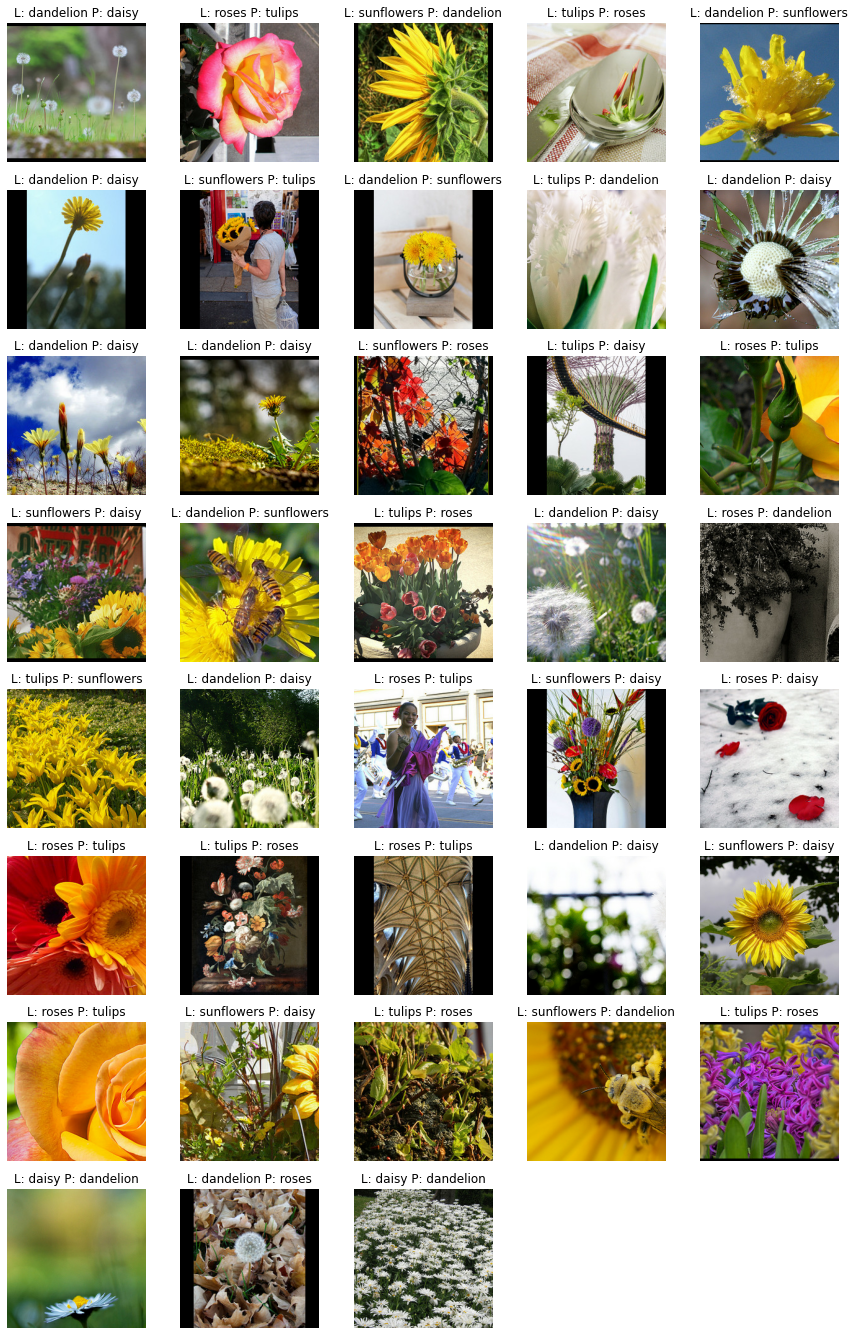

In [29]:
label_name = info.features['label'].names
def display_images(images, labels, predictions, cols=5):
  rows = int(math.ceil(len(images) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, label, pred) in enumerate(zip(images, labels, predictions)):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title("L: {} P: {}".format(label_name[int(label)], label_name[int(pred)]))
  
display_images(img_mis, lbl_mis, pred_mis)

Some of the images were mislabeled and many of them are difficult to classify examples. Finally, let's check our accuracy on test data.
### Test accuracy

In [30]:
model2.evaluate(test_ds)

3/3 [==============================] - 2s 449ms/step - loss: 0.3973 - accuracy: 0.9046


[0.39733654260635376, 0.9046321511268616]

Number of mistakes by label:

{'dandelion': 9, 'daisy': 2, 'tulips': 13, 'sunflowers': 4, 'roses': 7}


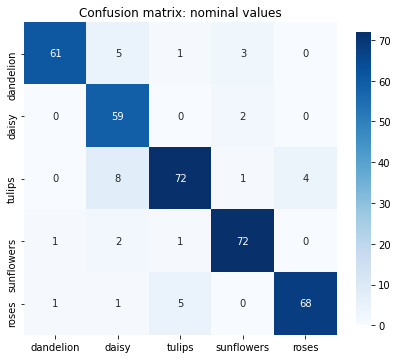

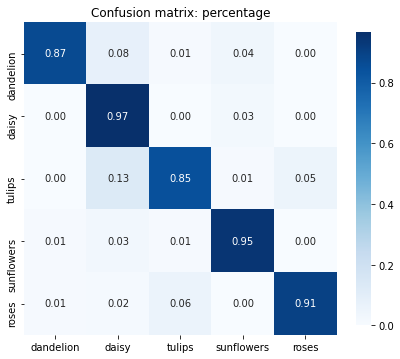

In [31]:
pred = model2.predict(test_ds)
pred_lbl = np.argmax(pred, axis = 1)
true_test = np.concatenate([lbl for img, lbl in test_ds], axis=0)
true_test_lbl = np.argmax(true_test, axis = 1)

def plot_conf(true, pred, norm = False):
  _ , ax = plt.subplots(figsize =(7, 6))
  conf = confusion_matrix(true, pred)
  fmt = 'd'
  ax_lbl = info.features['label'].names
  if norm:
    conf = conf.astype("float") / conf.sum(axis=1)
    fmt = '.2f'
    ax.set_title('Confusion matrix: percentage')
  else:
    ax.set_title('Confusion matrix: nominal values')
    mis = conf.sum(axis=1) - np.diag(conf)
    print("Number of mistakes by label:\n")
    print('{}'.format({a : b for a,b in zip(ax_lbl, mis)}))
  sns.heatmap(conf, xticklabels=ax_lbl, yticklabels=ax_lbl,
      cmap='Blues', annot=True, fmt=fmt, square=True, cbar_kws={'shrink':.9 },
      ax=ax)
  
plot_conf(true_test_lbl, pred_lbl)
plot_conf(true_test_lbl, pred_lbl, norm=True)

Test accuracy is on the same level as accuracy of validation test. With pre-trained model accuracy of 90% has been achieved. Further improvements would require correction of mislabeled examples, use of some additional augmentation techniques or getting more training data.